# Train VGG11 Model on MIT Indoor Scene Recognition 
- Input Size of 224x224x3


In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import tqdm

/opt/conda/envs/dd/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())

True


## Dataset
- There are 67 Indoor categories with a total of 15620 images. The number of images varies across categories, but there are at least 100 images per category. All images are in jpg format. 

In [3]:
!ls ../../../../data/indoorCVPR_09/Images

airport_inside	computerroom	     inside_subway   pantry
artstudio	concert_hall	     jewelleryshop   poolinside
auditorium	corridor	     kindergarden    prisoncell
bakery		deli		     kitchen	     restaurant
bar		dentaloffice	     laboratorywet   restaurant_kitchen
bathroom	dining_room	     laundromat      shoeshop
bedroom		elevator	     library	     stairscase
bookstore	fastfood_restaurant  livingroom      studiomusic
bowling		florist		     lobby	     subway
buffet		gameroom	     locker_room     toystore
casino		garage		     mall	     trainstation
children_room	greenhouse	     meeting_room    tv_studio
church_inside	grocerystore	     movietheater    videostore
classroom	gym		     museum	     waitingroom
cloister	hairsalon	     nursery	     warehouse
closet		hospitalroom	     office	     winecellar
clothingstore	inside_bus	     operating_room


In [4]:
data_dir = '../../../../data/indoorCVPR_09/Images'
classes = os.listdir(data_dir)
print(f"There are {len(classes)} classes: \n {classes}")

There are 67 classes: 
 ['grocerystore', 'videostore', 'livingroom', 'office', 'toystore', 'gameroom', 'clothingstore', 'bookstore', 'dining_room', 'prisoncell', 'nursery', 'stairscase', 'tv_studio', 'deli', 'laundromat', 'elevator', 'florist', 'museum', 'cloister', 'bakery', 'bowling', 'pantry', 'bedroom', 'children_room', 'casino', 'auditorium', 'dentaloffice', 'kindergarden', 'movietheater', 'garage', 'waitingroom', 'meeting_room', 'computerroom', 'winecellar', 'bar', 'shoeshop', 'airport_inside', 'hairsalon', 'lobby', 'closet', 'subway', 'warehouse', 'corridor', 'gym', 'kitchen', 'buffet', 'library', 'jewelleryshop', 'poolinside', 'laboratorywet', 'classroom', 'hospitalroom', 'artstudio', 'greenhouse', 'studiomusic', 'concert_hall', 'restaurant_kitchen', 'operating_room', 'locker_room', 'fastfood_restaurant', 'inside_subway', 'bathroom', 'inside_bus', 'mall', 'church_inside', 'restaurant', 'trainstation']


# Data Transformations

In [5]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [6]:
# Helper function to see the image and labels
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: airport_inside (Class No: 0)


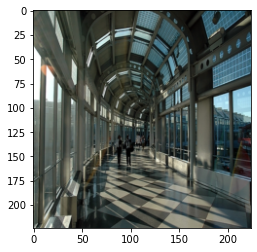

In [7]:
img, label = dataset[50]
show_sample(img, label)

# Load and Split Dataset

In [8]:
random_seed = 42
torch.manual_seed(random_seed)

In [9]:
len(dataset)

15620

In [10]:
train_set, val_set = random_split(dataset, [14000, 1620]) # used to be trained as (14620, 1000) 
len(train_set), len(val_set)

(14000, 1620)

In [11]:
from torch.utils.data.dataloader import DataLoader
batch_size = 25

In [12]:
# Create training and validating dataloaders with DataLoader
train_dl = DataLoader(train_set, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_set, batch_size, num_workers = 4, pin_memory=True)

In [13]:
# Visualize batches
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        print(f"Shape of images: {images.shape}")
        print(f"Shape of labels: {labels.shape}")
        print(f"labels {labels}")
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

Shape of images: torch.Size([25, 3, 224, 224])
Shape of labels: torch.Size([25])
labels tensor([41, 10, 34,  8, 60, 31, 35, 64, 55, 41, 60, 10, 14, 29,  2, 41, 40, 37,
         6, 53,  6, 37, 34, 38, 54])


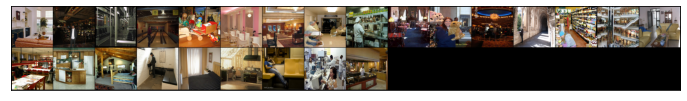

In [14]:
# Show training batch
show_batch(train_dl)

Shape of images: torch.Size([25, 3, 224, 224])
Shape of labels: torch.Size([25])
labels tensor([59, 17, 51, 14, 54,  0, 38, 48, 19, 10,  6, 59, 51, 25, 29, 22, 26, 19,
        61, 60,  6, 65, 41, 63, 20])


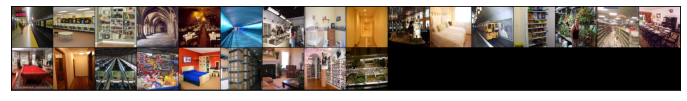

In [15]:
# Show testing batch
show_batch(val_dl)

In [16]:
# Check input size
next(iter(train_set))[0].shape

torch.Size([3, 224, 224])

# VGG11 Model

In [17]:
class NetVGG11(nn.Module):
    def __init__(self):
        super(NetVGG11, self).__init__()
        ### VGG Block 1
        # Conv2d - BatchNorm - ReLU - MaxPool2d
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        ### VGG Block 2
        # Conv2d - BatchNorm - ReLU - MaxPool2d
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=128)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        ### VGG Block 3
        # Conv2d - Conv2d - BatchNorm - ReLU - MaxPool2d
        self.conv3a = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=256)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        ### VGG Block 4
        # Conv2d - Conv2d - BatchNorm - ReLU - MaxPool2d
        self.conv4a = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4b = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=512)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        ### VGG Block 5
        # Conv2d - Conv2d - BatchNorm - ReLU - MaxPool2d
        self.conv5a = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5b = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=512)
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        ### Fully Connect Layers
        self.dense1 = nn.Linear(512*7*7, 4096)
        self.drop1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(4096, 4096)
        self.drop2 = nn.Dropout(0.5)
        self.dense3 = nn.Linear(4096, 1000)
        self.dense4 = nn.Linear(1000, len(dataset.classes))
        
    def forward(self, x):
        ### VGG Layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3a(x)
        x = self.conv3b(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
     
        x = self.conv4a(x)
        x = self.conv4b(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)
        
        x = self.conv5a(x)
        x = self.conv5b(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        
        ### Fully Connected Layers
        x = x.view(-1,512*7*7)
        x = self.dense1(x)
        x = F.relu(x)
        x = self.drop1(x)
        x = self.dense2(x)
        x = F.relu(x)
        x = self.drop2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        
        return x

In [18]:
vgg_net = NetVGG11()
vgg_net

NetVGG11(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (con

In [19]:
def evaluate_accuracy(data_iter, net, device=None):
    # If device is not specified, use net device
    if device is None and isinstance(net, torch.nn.Module):
        device = list(net.parameters())[0].device
    
    # Initialize accuracy
    acc_sum, n = 0.0, 0
    
    # For evaluation, no need to update gradient
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                # Evaluation mode, turn off dropout
                net.eval()  
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                
                # Change back to training mode
                net.train() 
            else:
                if ('is_training' in net.__code__.co_varnames):  # If there is a parameter of is_training
                    
                    # Set is_training to False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
    return acc_sum / n

In [20]:
def train(train_iter, test_iter, net, optimizer, device, num_epochs):
    # Deploy the network on the gpu device
    net = net.to(device)
    print("training on", device)
    
    # Cross entropy
    loss = torch.nn.CrossEntropyLoss()
    batch_count = 0
#     collaps = 0
    
#     simplex = torch.zeros(len(train_iter.dataset), len(dataset.classes)).to(device)
    
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for  X, y in train_iter:
            
            # Input attributes
            X = X.to(device)
            
            # Tags
            y = y.to(device)
            
            # Prediction
            y_hat = net(X)
            
#             print(y_hat[0])
#             print(y)
#             print('-------')
            
            # Calculate loss
            l = loss(y_hat, y)
            
            # Gradient descent
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
            
        # Test set accuracy
        test_acc = evaluate_accuracy(test_iter, net)
        
        print(f"epoch: {epoch + 1}, loss: {train_l_sum / batch_count}, train acc: {train_acc_sum / n}, test acc: {test_acc}, collaps: {time.time() - start}")

In [21]:
# lr = 0.003
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# loss_criterion = nn.CrossEntropyLoss()
vgg_net = NetVGG11().to(device)
optimizer = torch.optim.SGD(vgg_net.parameters(), lr=0.001, momentum=0.9)

# optimizer = torch.optim.Adam(vgg_net.parameters(), lr=0.001)
train(train_dl, val_dl, vgg_net, optimizer, device, num_epochs)

training on cuda
epoch: 1, loss: 3.691110699091639, train acc: 0.10035714285714285, test acc: 0.13641975308641976, collaps: 107.14363145828247
epoch: 2, loss: 1.6668638099517141, train acc: 0.15335714285714286, test acc: 0.145679012345679, collaps: 106.21196985244751
epoch: 3, loss: 1.039491337821597, train acc: 0.1962142857142857, test acc: 0.2617283950617284, collaps: 106.12224793434143
epoch: 4, loss: 0.7138003908097744, train acc: 0.25307142857142856, test acc: 0.2740740740740741, collaps: 106.40213584899902
epoch: 5, loss: 0.5289162813339915, train acc: 0.2982142857142857, test acc: 0.2740740740740741, collaps: 106.16242241859436
epoch: 6, loss: 0.4116388859493392, train acc: 0.3354285714285714, test acc: 0.26358024691358023, collaps: 105.56114387512207
epoch: 7, loss: 0.3288738309424751, train acc: 0.37064285714285716, test acc: 0.34444444444444444, collaps: 106.93048977851868
epoch: 8, loss: 0.2698093311595065, train acc: 0.406, test acc: 0.37222222222222223, collaps: 105.578686

# Save Model

In [46]:
!ls ../../../../

data  data.zip	deepdream_college  trained_models


In [47]:
path_save = "../../../../trained_models/vgg_11_epoch_100_train_99_test_55.h5"

In [48]:
torch.save(vgg_net.state_dict(), path_save)

# Load and Evaluate Trained Model

In [49]:
new_vgg_11 = NetVGG11().to(device)
new_vgg_11.load_state_dict(torch.load(path_save))

<All keys matched successfully>

In [50]:
new_vgg_11

NetVGG11(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (con

In [51]:
test_acc = evaluate_accuracy(val_dl, new_vgg_11)

In [52]:
print(f"The test acccuracy of VGG11 is: {test_acc}")

The test acccuracy of VGG11 is: 0.5524691358024691


# Visualize Predictions

In [53]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0).to(device)
    
    # Get predictions from model
    yb = model(xb)
    
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: subway , Predicted: subway


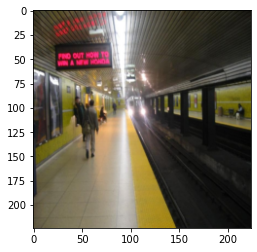

In [54]:
img, label = val_set[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, new_vgg_11))